## Dependencies & File paths ##

In [1]:
#uncomment when using Google colab
#from google.colab import drive
#drive.mount('/content/gdrive')

basepath=''
#basepath='/content/gdrive/My Drive/ML/starterskit'

In [2]:
# standard packages used to handle files
import sys
sys.path.append(basepath)

import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook
%matplotlib notebook

# for modeling
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score 
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

# classifier and pipeline methods
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, Pipeline

# feature selection
from sklearn.feature_selection import SelectKBest, RFE, RFECV, chi2, VarianceThreshold, SelectFromModel, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LassoCV, RidgeCV,LassoLarsCV

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# for preprocessing
from sklearn.preprocessing import StandardScaler,scale

# imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# calibration
from sklearn.calibration import CalibratedClassifierCV

# suppress solver warnings
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')

In [3]:
# filepath constants, set these according to your workflow:

# where are your datasets:
dataset_path = '../images/'
# where do you want to save your features and other outputs:
output_path = './'

In [4]:
# you don't have to change the paths here:

dataset_path_train = os.path.join(basepath,dataset_path, 'train')
dataset_path_test = os.path.join(basepath,dataset_path, 'test')

features_path = os.path.join(basepath,output_path, 'features')
features_path_train = os.path.join(basepath,features_path, 'train')
features_path_test = os.path.join(basepath,features_path, 'test')

prediction_path = os.path.join(basepath,output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

## Loading the data and the labels

In [5]:
folder_paths = glob.glob(os.path.join(dataset_path_train, '*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]

print("Amount of classes: ", num_classes)
print("\nLabels: \n", label_strings)

Amount of classes:  12

Labels: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


In [6]:
#build a dictionary of the filepaths to all our train/test images, sorted by label
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

## Preliminary Data analysis

We are working with a supervised multiclass classification problem.

We know there are 12 different classes, but we don't know how balanced those classes are in our available data.
We are going to calculate and plot the amount of images that are available for each of our classes.

<IPython.core.display.Javascript object>


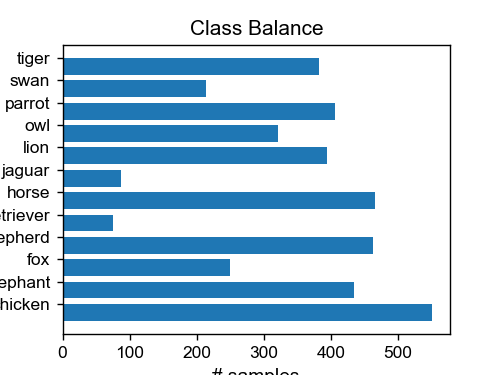

In [7]:
# calculate the amount of training samples there are for each label
sample_size_dict = {key: len(value) for key, value in train_paths.items()}

x = sample_size_dict.keys()
y = sample_size_dict.values()
classes = x
sample_sizes = y


SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12    

figure, axes = plt.subplots(figsize=(4, 3))    
bar_width = 0.75 
class_index = np.arange(len(classes)) 
axes.barh(class_index, sample_sizes, bar_width)
axes.set_yticks(class_index+bar_width/2)
axes.set_yticklabels(classes, minor=False,fontsize=SMALL_SIZE)
axes.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
plt.title('Class Balance',fontsize=BIGGER_SIZE)
plt.xlabel('# samples',fontsize=MEDIUM_SIZE)
plt.ylabel('Animal classes',fontsize=MEDIUM_SIZE)
#plt.show()
plt.savefig(os.path.join('class_balance.svg'), dpi=300, format='svg', bbox_inches='tight')

It is immediately clear that some classes are represented more in our training data than others. This class imbalance should be taken into account when creating our models.

Let's also keep track of the prior probabilities of each class. They might come in handy later on for some models (like Naive Bayes).

In [8]:
prior_predictions = np.array([len(train_paths[label]) for label in label_strings])
prior_predictions = prior_predictions / np.sum(prior_predictions)
print(label_strings)
print(prior_predictions)

['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']
[0.13607125 0.10761999 0.06160317 0.11429985 0.01855517 0.11528946
 0.021524   0.0974765  0.07941613 0.10044532 0.05294409 0.09475507]


In [9]:
# available descriptors
descriptors=['boost', 'daisy', 'freak', 'lucid', 'orb', 'sift', 'vgg']

## Helper functions

In [10]:
# helper function to collect all tested models and their hyperparameters to tune
def Model():
    '''
    There are total 8 algorithm with list of their hyperparameters
    1. Logistic Regression (linear)
    2. K Neighbors Classifiers (non-linear)
    3. Decision Tree (non-linear)
    4. Naive Bayes (non-linear)
    5. Support Vector Classifiers (non-linear)
    6. Random Forest (non-linear)
    Return:
    all the models along with their name, list of hyperparamaters and short_name
    '''
    # Hyperparameters for Logistic Regression
    LRparams = {
        "class_weight":["balanced"],
        "C" :[0.1, 1, 10,100],
        #"solver":["liblinear","lbfgs"],
    }
    # Hyperparameters for K Neighbors Classifiers
    KNNparams = {
        'n_neighbors':[5,6,7,8,9,10],
        'leaf_size':[1,2,3,5],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree','kd_tree','brute'],
        'n_jobs':[-1]
    }
    # Hyperparameters for Decision Tree
    DTparams = {
        "max_depth": [3, 5 , 10, None],
        "max_features": ["auto", "sqrt", "log2", None],
        "min_samples_leaf": [1,5,10,50],
        "criterion": ["gini", "entropy"],
        "class_weight":["balanced"]
    }
    # Hyperparameters for Naive Bayes
    NBparams = {
        'var_smoothing': np.logspace(0,-9, num=100)   
    }
    # Hyperparameters for Support Vector Classifiers
    SVCparams = {
        'kernel': ['rbf','linear'], 
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,'auto'],
        'C': [1, 6, 7, 8, 9, 10, 11, 12, 10, 50, 100, 200, 300],
        'class_weight': ['balanced'],
        'probability': [True]
    }
    #Hyperparameters for Random Forest
    RFparams = {
        'n_jobs':[-1],
        'criterion':['entropy'],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'class_weight' : ["balanced", "balanced_subsample"],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }

    # Models
    models = []
    #models.append(('Logistic Regression', LogisticRegression(random_state=42), LRparams,'LR'))
    #models.append(('K Neighbors Classifiers', KNeighborsClassifier(), KNNparams,'KNN'))
    #models.append(('Decision Tree', DecisionTreeClassifier(random_state=42), DTparams,'DT'))
    #models.append(('Naive Bayes', GaussianNB(), NBparams,'NB'))
    #models.append(('Support Vector Classifiers', SVC(random_state=42), SVCparams,'SVC'))
    models.append(('Random Forest', RandomForestClassifier(random_state=42), RFparams,'RF'))
    return models

In [11]:
# helper function to train and select a best performing method (no pipeline)
def trainWithBestModelAndParams(X_train, X_test, y_train, y_test, Modeltype, Test, CV=5, Scaling=False):
    '''
    Select Best ML model with their best hyperparamaters
    
    Parameters:
    X_train: train data
    X_test: Sample test data
    y_train: train true label
    y_test: Sample Test true label
    Test: test data for submission
    CV: Number of cross-validation folds
    Scaling: For Scaling of Input varaibles 
    
    Return:
    Best Classifiers   
    '''
    models = Model()
    # Scaling Features
    if Scaling:
        X_train, X_test, Test = scale(X_train, X_test, Test)

    #RandomSearch or GridSearch    
    result = []
    print('{:31}| {:6} | {}'.format('Estimator', 'Score', 'Best Parameters'))
    print('-'*180)
    for name, model, params, abr in models:
        #rs=GridSearchCV(model,param_distributions = params ,verbose=0, n_jobs=-1, 
        #                scoring='neg_log_loss',cv = CV, random_state=42)
        rs=RandomizedSearchCV(model ,param_distributions = params ,verbose=0, n_jobs=-1, scoring='neg_log_loss',cv = CV, 
                              n_iter=30, random_state=42,refit='neg_log_loss')
        rs.fit(X_train,y_train)
        result.append((name, rs.best_score_, rs.best_params_, rs.best_estimator_, abr))
        print('{:31}| {:.4f} | {}'.format(name, rs.best_score_, rs.best_params_))

    # Selecting Best Score Model
    mx = -3
    best_model = 0
    for i in result:
        if(i[1]>mx):
            mx = i[1]
            best_model = i
    print('_'*180)
    print('{:15}:{}'.format('Best Model', best_model[0]))
    print('{:15}:{:.4}'.format('CV Score', best_model[1]))
    print('{:15}:{}'.format('Parameters', best_model[2]))
    print('{:15}:{}'.format('Estimator', best_model[3]))
    print('_'*180)
    
    #Training Models
    print('Training Models..')
    classifiers = []
#     for i, model in enumerate(result):
#         clf = model[3]
#         clf = CalibratedClassifierCV(clf, cv=10, method='sigmoid') # turn classifier score into probability
#         clf.fit(X_train,y_train)

#         #Append classifier into list
#         classifiers.append((model[0], clf))

#         Predicting
#         pred = clf.predict_proba(Test)[:,1]

#         print(model[0]+' done.')
    print('_'*180)
    classifiers = dict(classifiers)
    return best_model, classifiers

In [12]:
# helper method for filtering out highly correlated features
def correlationFiltering(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

In [16]:
# SFS method
def SequentialFeatureSelection(X_train, y_train, n_features, Floating=False, Forward=False, Scoring='neg_log_loss',):
    '''
    Select important features using SFS technique and LinearSVC classifiers
    X_train: train data
    y_train: train label
    Floating: add Foalting or not
    Return:
    Selector object
    '''
    # Scaling Features
    scale = StandardScaler()
    Xsfs_train = scale.fit_transform(X_train)

    # Define LinearSVC parameters
    svc = LinearSVC(C=0.01, tol=0.0001, verbose=0, random_state=101, max_iter=2000, dual=False)
    # calibrated classifier
    sigmoid = CalibratedClassifierCV(svc, cv=2, method='sigmoid')

    # Select between 10 and 20 features starting from 1
    sfs = SFS(sigmoid,
        k_features=n_features,
        forward=Forward,
        floating=Floating,
        scoring=Scoring,
        cv=list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(Xsfs_train,y_train)),
        n_jobs=-1
    )

    sfs.fit(Xsfs_train, y_train, custom_feature_names=X_train.columns)

    return sfs

In [17]:
# helper function to obtain image feature vectors for a specific descriptor and codebook size
def obtain_image_features(desired_descriptor, codebook_size):
    # load pickle files
    with open(filepattern_descriptor_train.format(desired_descriptor), 'rb') as pkl_file_train:
        train_features_from_pkl = pickle.load(pkl_file_train)
    
    print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))
    
    with open(filepattern_descriptor_test.format(desired_descriptor), 'rb') as pkl_file_test:
        test_features_from_pkl = pickle.load(pkl_file_test)
        
    print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))
    
    # create codebook
    clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)
    
    # encode all train images 
    train_data = []
    train_label_strings = []

    for image_features in train_features_from_pkl:
        bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
        train_data.append(bow_feature_vector)
        train_label_strings.append(image_features.label)
    
    # encode all test images 
    test_data = []
    for image_features in test_features_from_pkl:
        bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
        test_data.append(bow_feature_vector)
        
    return train_data, train_label_strings, test_data

In [18]:
# helper function to encode the training labels to obtain numerical labels    
def encodeLabelStrings(train_label_strings):
    label_encoder = sklearn.preprocessing.LabelEncoder()
    label_encoder.fit(train_label_strings)

    return label_encoder.transform(train_label_strings)

In [19]:
# Helper class to create a stratified repeatable random test/validation split.
def createStratifiedTrainingSplit(X, target, test_fraction=0.20):
    test_fraction = 0.20
    x_train, x_test, y_train, y_test = train_test_split(X, target, test_size = test_fraction, stratify=target, random_state=123)
    
    return x_train, x_test, y_train, y_test

## Feature extraction

In [33]:
desired_descriptor='sift'
codebook_size=500

In [34]:
# create the feature vectors and labels
train_data, train_label_strings, test_data=obtain_image_features(desired_descriptor, codebook_size)

# encode the training labels to obtain numerical labels    
train_labels = encodeLabelStrings(train_label_strings)

Number of encoded train images: 4042
Number of encoded test images: 4035
training took 85.34354996681213 seconds


## Data analysis

In [35]:
# print the obtained feature vectors with their labels for a quick look
X = pd.DataFrame(train_data)
y = pd.DataFrame(train_labels)

# have a truncated look at the data
X.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,0.058977,0.176930,0.058977,0.058977,0.147442,0.029488,0.029488,0.029488,0.000000,...,0.0,0.0,0.029488,0.029488,0.029488,0.000000,0.000000,0.000000,0.029488,0.029488
1,0.031281,0.000000,0.062561,0.031281,0.000000,0.093842,0.000000,0.093842,0.000000,0.000000,...,0.0,0.0,0.000000,0.031281,0.000000,0.062561,0.000000,0.000000,0.062561,0.000000
2,0.018493,0.018493,0.000000,0.055480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.018493,0.055480,0.018493,0.018493,0.018493,0.000000,0.000000,0.036986
3,0.000000,0.120006,0.060003,0.030002,0.030002,0.000000,0.060003,0.000000,0.060003,0.030002,...,0.0,0.0,0.000000,0.000000,0.030002,0.000000,0.030002,0.000000,0.030002,0.000000
4,0.000000,0.068399,0.034199,0.000000,0.000000,0.136797,0.068399,0.000000,0.034199,0.034199,...,0.0,0.0,0.034199,0.034199,0.205196,0.102598,0.136797,0.102598,0.034199,0.034199


In [36]:
# print the obtained feature vectors with their labels for a quick look
data = np.c_[X, y]
print(pd.RangeIndex(start=1, stop=codebook_size+1, step=1))
columns = np.append(X.columns, ["target"])
pd_data = pd.DataFrame(data, columns=columns)

# have a truncated look at the data
pd_data.head()

RangeIndex(start=1, stop=501, step=1)


,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,target
0,0.000000,0.058977,0.176930,0.058977,0.058977,0.147442,0.029488,0.029488,0.029488,0.000000,...,0.0,0.029488,0.029488,0.029488,0.000000,0.000000,0.000000,0.029488,0.029488,0.0
1,0.031281,0.000000,0.062561,0.031281,0.000000,0.093842,0.000000,0.093842,0.000000,0.000000,...,0.0,0.000000,0.031281,0.000000,0.062561,0.000000,0.000000,0.062561,0.000000,0.0
2,0.018493,0.018493,0.000000,0.055480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.018493,0.055480,0.018493,0.018493,0.018493,0.000000,0.000000,0.036986,0.0
3,0.000000,0.120006,0.060003,0.030002,0.030002,0.000000,0.060003,0.000000,0.060003,0.030002,...,0.0,0.000000,0.000000,0.030002,0.000000,0.030002,0.000000,0.030002,0.000000,0.0
4,0.000000,0.068399,0.034199,0.000000,0.000000,0.136797,0.068399,0.000000,0.034199,0.034199,...,0.0,0.034199,0.034199,0.205196,0.102598,0.136797,0.102598,0.034199,0.034199,0.0


In [37]:
# missing values check
missing = 0
for col in pd_data.columns:
    if(pd_data[col].isnull().any()):
        print(col,'has missing values')
        missing = 1
if(missing==0):
    print('There are no missing values')

There are no missing values


In [38]:
print(X.skew())
print(X.kurtosis())

0      1.791057
1      2.154785
2      1.719497
3      1.605808
4      1.493132
         ...   
495    1.555846
496    1.843752
497    2.015357
498    1.515941
499    1.981134
Length: 500, dtype: float64
0      4.739129
1      6.973020
2      3.881713
3      3.667959
4      3.037207
         ...   
495    2.712510
496    4.647478
497    6.535945
498    3.149587
499    5.085634
Length: 500, dtype: float64


<IPython.core.display.Javascript object>


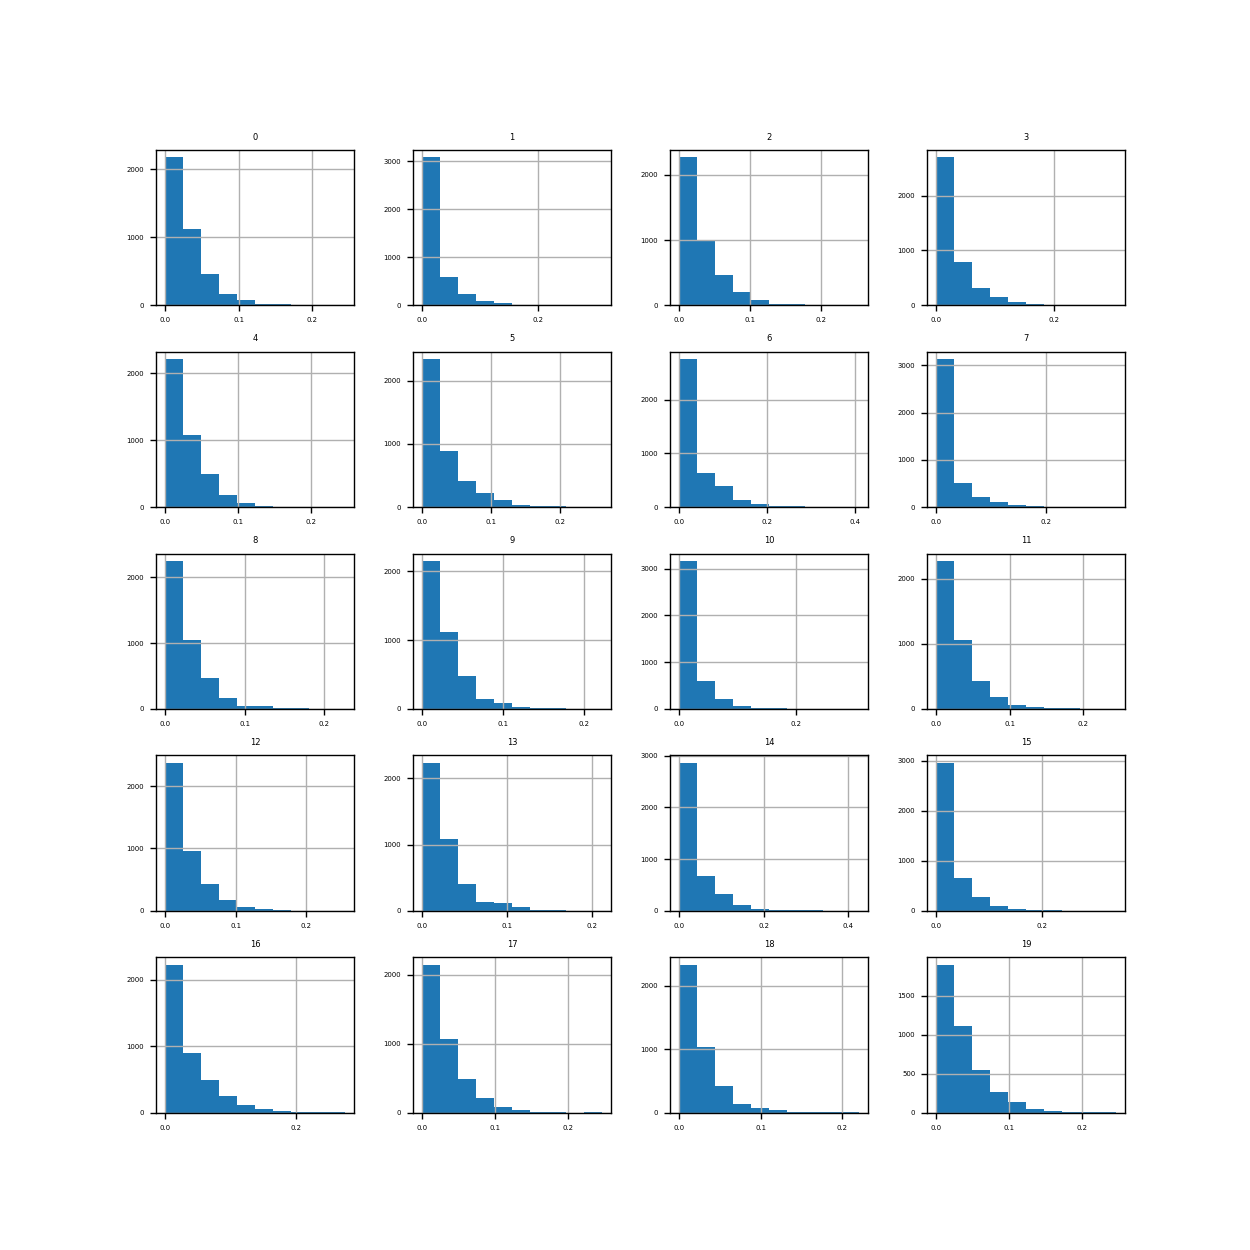

In [39]:
#histograms
font = {'family' : 'normal',
         'weight' : 'normal',
         'size'   : 4}
plt.rc('font', **font)

X.iloc[:, : 20].hist(figsize = (10,10),label='') # figsize: (width,height)
#X.hist(figsize = (16,16)) 
plt.show()
#plt.savefig(os.path.join('histograms.svg'), dpi=300, format='svg', bbox_inches='tight')
#plt.rcParams.update(plt.rcParamsDefault)

In [40]:
#correlation to target
corr_matrix = pd_data.corr().abs()
top_20_correlation=corr_matrix['target'].sort_values(ascending=False).head(21)[1:21]

In [41]:
top_20_correlation.values.tolist()

[0.32364052691371353,
 0.31722228988958173,
 0.3132613548051045,
 0.3055280901797003,
 0.30549907251133857,
 0.29861097103304846,
 0.2950635319487626,
 0.28959341974562497,
 0.28670305660171724,
 0.28391852269075707,
 0.2829838653571959,
 0.28168694639335035,
 0.27777633974548244,
 0.27670436367577045,
 0.27477505677689373,
 0.2706214320641215,
 0.27022059962177547,
 0.2698340476095265,
 0.2668870643688413,
 0.2646158587470217]

<IPython.core.display.Javascript object>


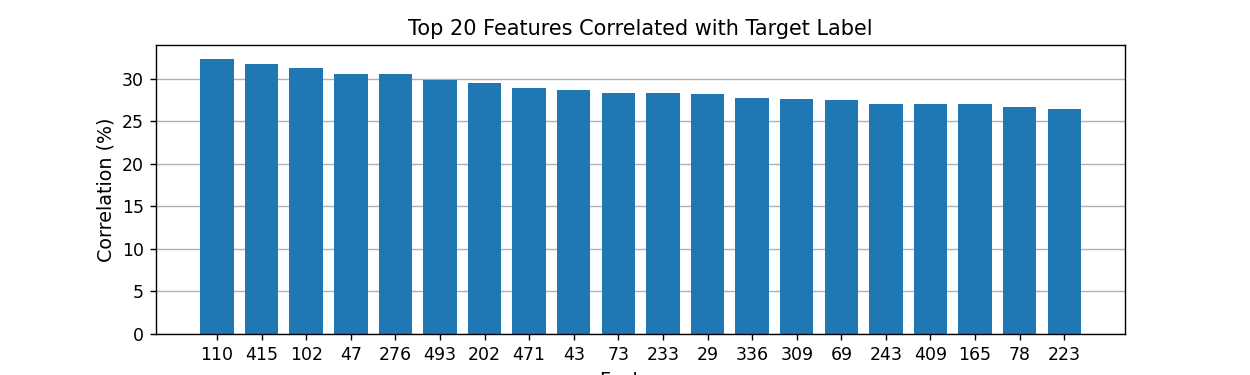

In [43]:
x = top_20_correlation.index.values.tolist()
y = top_20_correlation.values*100

SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12    

figure, axes = plt.subplots(figsize=(10, 3))    
bar_width = 0.75  
axes.set_axisbelow(True)
axes.grid(axis='y')
axes.bar(x, y, bar_width)
axes.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
plt.title('Top 20 Features Correlated with Target Label',fontsize=BIGGER_SIZE)
plt.xlabel('Features', fontsize=MEDIUM_SIZE)
plt.ylabel('Correlation (%)', fontsize=MEDIUM_SIZE)
#plt.show()
plt.savefig(os.path.join('top20.svg'), dpi=300, format='svg', bbox_inches='tight')

In [44]:
# Select upper triangle of correlation matrix
corr_matrix = X.iloc[:, : 500].corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_show = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.5)]
highly_correlated_X=X[to_show]

corr_matrix = highly_correlated_X.corr()
mask = np.zeros(corr_matrix.shape, dtype=bool)
mask[np.tril_indices(len(mask))] = True
print(len(to_show))

34


<IPython.core.display.Javascript object>


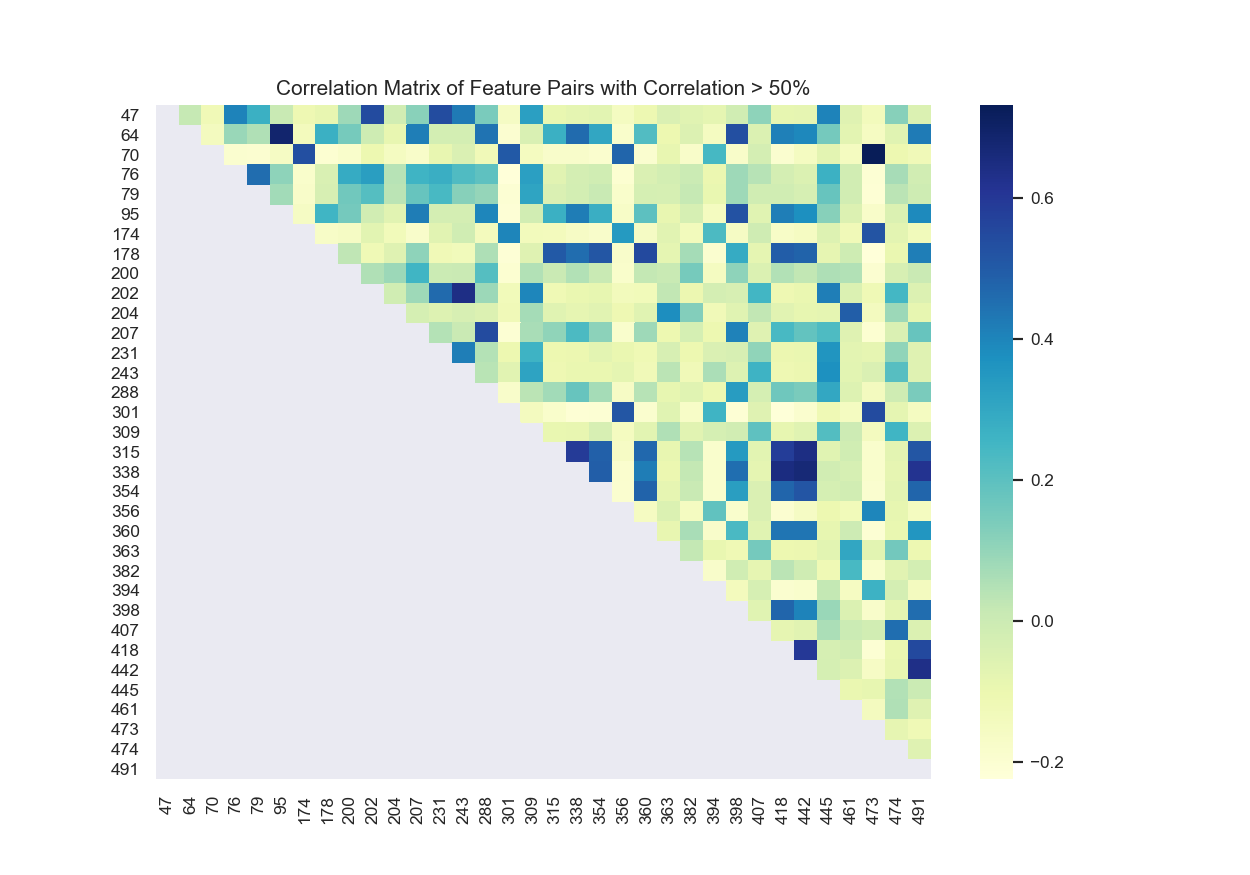

In [68]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12    

sns.set(font_scale=0.9)
plt.figure(figsize=(10,7))
ax = plt.axes()
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
#plot heat map
g=sns.heatmap(corr_matrix, annot = False, mask = mask, cmap='YlGnBu')#,
              #cbar_kws = dict(use_gridspec=False,location="bottom"))
               #xticklabels=5, yticklabels=5)
ax.set_title('Correlation Matrix of Feature Pairs with Correlation > 50%', fontsize=BIGGER_SIZE)
plt.yticks(rotation=0) 
plt.show()

In [69]:
ax.figure.savefig(os.path.join('correlation matrix.svg'), format='svg', bbox_inches='tight')

## Training split

In [23]:
# create a training split
#X_train, X_test, y_train, y_test = createStratifiedTrainingSplit(X, train_labels, test_fraction=0.8)
X_train, X_test, y_train, y_test = createStratifiedTrainingSplit(train_data, train_labels, test_fraction=0.8)

## Baseline models

In [22]:
scoring_metric='neg_log_loss'
classifier_name="SVM"
classifier=SVC

In [192]:
baseline_best_model, BM_clfs = trainWithBestModelAndParams(X_train, X_test, y_train, y_test, 'Baseline', test_data, CV=5, Scaling=False)

Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest                  | -1.8548 | {'n_jobs': -1, 'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 70, 'criterion': 'entropy', 'class_weight': 'balanced'}
____________________________________________________________________________________________________________________________________________________________________________________
Best Model     :Random Forest
CV Score       :-1.855
Parameters     :{'n_jobs': -1, 'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 70, 'criterion': 'entropy', 'class_weight': 'balanced'}
Estimator      :RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=70, n_estimators=1800, n_jobs=-1,
          

## SMOTE

### Oversampling

In [127]:
# original count per class in training data
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),
 array([440, 348, 199, 369,  60, 373,  70, 315, 257, 325, 171, 306],
       dtype=int64))

In [84]:
# originally: 
#{0: 440, 1: 348, 2: 199, 3: 369, 
#4: 60, 5: 373, 6: 70, 7: 315, 8: 257, 9: 325, 
#10: 171, 11: 306}
smote_dict={0: 440, 1: 348, 2: 199, 3: 369, 
            4: 120, 5: 373, 6: 120, 7: 315, 8: 257, 9: 325, 
            10: 171, 11: 306}

In [85]:
smote = SMOTE(sampling_strategy=smote_dict)
Xo_train, yo_train = smote.fit_sample(X_train, y_train)
print(Xo_train.shape, yo_train.shape)

overSample_best_model, OS_clfs = trainWithBestModelAndParams(Xo_train, X_test, yo_train, y_test, 'OverSample', test_data, CV=5, Scaling=False)

(3343, 750) (3343,)


### Over- and undersampling

In [33]:
# originally: 
#{0: 440, 1: 348, 2: 199, 3: 369, 
#4: 60, 5: 373, 6: 70, 7: 315, 8: 257, 9: 325, 
#10: 171, 11: 306}
smote_dict={0: 440, 1: 348, 2: 199, 3: 369, 
            4: 60, 5: 373, 6: 70, 7: 315, 8: 257, 9: 325, 
            10: 171, 11: 306}

In [37]:
smote = SMOTE(sampling_strategy=smote_dict)
Xo_train, yo_train = smote.fit_sample(X_train, y_train)
print(Xo_train.shape, yo_train.shape) # (269, 300) (269,)

under = RandomUnderSampler(sampling_strategy='not minority')
Xou_train, you_train = under.fit_resample(Xo_train, yo_train)
print(Xou_train.shape, you_train.shape) # (230, 300) (230,)

overUnderSample_best_model, OUS_clfs = trainWithBestModelAndParams(Xou_train, X_test, you_train, y_test, 
                                                                   'OverUnderSample', test_data, CV=5,
                                                                   Scaling=False)

(3233, 500) (3233,)
(720, 500) (720,)
Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | -2.1332 | {'tol': 0.0003, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'intercept_scaling': 4, 'class_weight': 'balanced', 'C': 1}
____________________________________________________________________________________________________________________________________________________________________________________
Best Model     :Logistic Regression
CV Score       :-2.133
Parameters     :{'tol': 0.0003, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'intercept_scaling': 4, 'class_weight': 'balanced', 'C': 1}
Estimator      :LogisticRegression(C=1, class_weight='balanced', intercept_scaling=4,
                   penalty='l1', random_state=42, solver='liblinear',
  

## Feature selection

### Filter

In [251]:
# print the obtained feature vectors with their labels for a quick look
train_data = np.c_[X_train, y_train]
print(pd.RangeIndex(start=1, stop=codebook_size+1, step=1))
columns = np.append(X_train.columns, ["target"])
pd_train_data = pd.DataFrame(train_data, columns=columns)

# have a truncated look at the data
pd_train_data.head()

RangeIndex(start=1, stop=751, step=1)


,0,1,2,3,4,5,6,7,8,9,...,741,742,743,744,745,746,747,748,749,target
0,0.032026,0.032026,0.000000,0.000000,0.032026,0.000000,0.032026,0.032026,0.032026,0.192154,...,0.0,0.064051,0.032026,0.000000,0.032026,0.000000,0.000000,0.032026,0.000000,8.0
1,0.032108,0.000000,0.032108,0.032108,0.000000,0.000000,0.032108,0.000000,0.000000,0.064216,...,0.0,0.032108,0.032108,0.096324,0.000000,0.000000,0.000000,0.032108,0.032108,3.0
2,0.000000,0.028868,0.000000,0.000000,0.000000,0.028868,0.057735,0.115470,0.028868,0.057735,...,0.0,0.028868,0.000000,0.028868,0.028868,0.057735,0.028868,0.115470,0.144338,7.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,0.034816,0.000000,0.069631,0.000000,0.000000,0.000000,0.034816,0.000000,0.000000,0.000000,...,0.0,0.034816,0.000000,0.000000,0.034816,0.000000,0.000000,0.034816,0.104447,1.0


In [256]:
# select all feature columns over a certain threshold
corr_matrix = pd_train_data.corr().abs()
sorted_target_corr_matrix=corr_matrix['target'].sort_values(ascending=False)
sorted_target_corr_matrix=sorted_target_corr_matrix[sorted_target_corr_matrix>0.10].iloc[1:]

filtered_X=pd_train_data[sorted_target_corr_matrix.index.values]
print(filtered_X.shape)

(3233, 315)


In [ ]:
# filter out highly correlated feature pairs (one of both)
correlationFiltering(filtered_X, 0.5)
print(len(filtered_X.columns))

In [43]:
# mutual information
select_k = 200
selection = SelectKBest(mutual_info_classif, k=select_k).fit(X_train, y_train)
print('Best {} selected Features are: {}'.format(select_k, list(X_train.columns[selection.get_support()])))

#Traforming train and test data with selected features
Xmi_train = selection.transform(X_train)
Xmi_test = selection.transform(X_test)
test_mi = selection.transform(test_data)
print(Xmi_train.shape, y_train.shape) #(240, 20) (240,)
print(Xmi_test.shape, y_test.shape) #(10, 20) (10,)
print(test_mi.shape) #(19750, 20)

#Training Model
MI_best_model, MI_clfs = trainWithBestModelAndParams(Xmi_train, Xmi_test, y_train, y_test, 'MI', test_mi, 
                                                     CV=5,Scaling=False)

Best 20 selected Features are: [22, 38, 45, 51, 83, 101, 178, 180, 186, 205, 276, 329, 342, 355, 367, 414, 443, 464, 485, 495]
(3233, 20) (3233,)
(809, 20) (809,)
(4035, 20)
Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | -2.0096 | {'tol': 0.0003, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'intercept_scaling': 2, 'class_weight': 'balanced', 'C': 100}
____________________________________________________________________________________________________________________________________________________________________________________
Best Model     :Logistic Regression
CV Score       :-2.01
Parameters     :{'tol': 0.0003, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'intercept_scaling': 2, 'class_weight': 'balanced', 'C': 100}
Estimator      :Log

In [238]:
#chi2
selector = SelectKBest(chi2, k=600).fit(X_train, y_train)
Xrfe_train=selector.transform(X_train)

In [257]:
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(classifier(C=10,probability=True), filtered_X, y_train, 
                           scoring=scoring_metric, cv=5, n_jobs=-1)
# report performance
print("Average validation accuracy: ",n_scores.mean(),", stdev: ",n_scores.std())

Average validation accuracy:  -1.5529908757577668 , stdev:  0.02527563002241548


### Wrapper

In [ ]:
# sequential feature selection
sfs=SequentialFeatureSelection(X_train, y_train, 300)
  
#Transforming train and test data with selectd faetures
Xsfs_train = sfs.transform(X_train)
Xsfs_test = sfs.transform(X_test)
test_sfs = sfs.transform(test_data)
print(Xsfs_train.shape, y_train.shape) 
print(Xsfs_test.shape, y_test.shape) 
print(test_sfs.shape)

# Training Model
SFS_best_model, SFS_clfs = trainWithBestModelAndParams(Xsfs_train, Xsfs_test, y_train, y_test, 'SFS', test_sfs, CV=5)

In [107]:
Modeltype = 'RFE'

#Scaling
scl = StandardScaler()
Xrfe_temp = scl.fit_transform(X_train)
#Xrfe_train, Xrfe_test, test_rfe = scale(X_train, X_test, test)

In [157]:
#Fitting to baseline model
#baseline_best_model[3]
#clf = SVC(C=1, kernel='linear')
#clf = RandomForestClassifier(n_jobs= -1, n_estimators= 1800, max_depth=30)
clf=LogisticRegression(C=10)

In [158]:
#Training with best features selected by RFE during traning
selector = RFE(clf, n_features_to_select=400, step=25)
#selector = RFECV(clf, n_features_to_select=300, step=25,cv=5)
selector.fit(X_train,y_train)

C:\Users\Robin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Robin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RFE(estimator=LogisticRegression(C=10), n_features_to_select=400, step=25)

In [159]:
# transform the data
Xrfe_train = selector.transform(X_train)
Xrfe_test = selector.transform(X_test)

In [149]:
print(len(X_train[0]))
print(len(Xrfe_train[0]))

750
400


In [150]:
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(classifier(C=10,probability=True), Xrfe_train, y_train, 
                           scoring=scoring_metric, cv=5, n_jobs=-1)
# report performance
print("Average validation accuracy: ",n_scores.mean(),", stdev: ",n_scores.std())

Average validation accuracy:  -1.3717493476417915 , stdev:  0.03902445835846977


In [205]:
# embedded techniques
embd_models =  [
    ('LassoCv' , LassoCV(alphas =  [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], n_jobs=-1) ),
    #('LassoLarsCV', LassoLarsCV(n_jobs=-1) ),
    #('RidgeCV', RidgeCV() )
]

Modeltype = 'EmbeddedF'

for model in embd_models:
    clf = model[1]
    clf.fit(X_train, y_train)

In [223]:
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(classifier(), X_train_selected, y_train, scoring=scoring_metric, cv=5, n_jobs=-1)
# report performance
print("Average validation accuracy: ",n_scores.mean(),", stdev: ",n_scores.std())

Average validation accuracy:  -1.4198690622815051 , stdev:  0.028481572864310252


## Dimensionality reduction

<IPython.core.display.Javascript object>


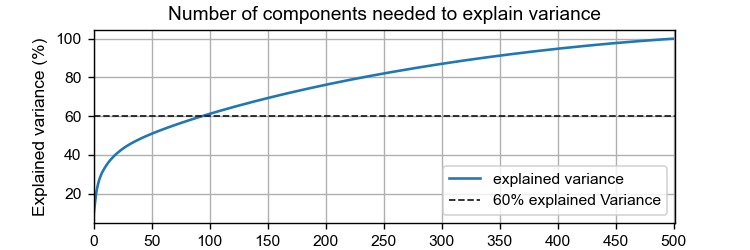

In [224]:
pca = PCA().fit(X_train)

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SMALL_SIZE = 9
MEDIUM_SIZE = 10
BIGGER_SIZE = 11    

#font = {'size'   : 9}
#plt.rc('font', **font)

fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

#plt.rcParams["figure.figsize"] = (4,2)
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, label='explained variance')
plt.xticks(np.arange(0, 501, step=50))
plt.xlabel('Number of components', fontsize=MEDIUM_SIZE)
plt.xlim(0,501)
plt.ylabel('Explained variance (%)', fontsize=MEDIUM_SIZE)
plt.axhline(y = 60, color='k', linestyle='--', linewidth=1, label = '60% explained Variance')
plt.title('Number of components needed to explain variance',fontsize=BIGGER_SIZE)
plt.legend(loc='best',fontsize=SMALL_SIZE)
#plt.show()
plt.savefig(os.path.join('pca.svg'), dpi=300, format='svg', bbox_inches='tight')

In [28]:
pca = PCA(0.7)
pca.fit(X_train)
lX_train = pca.transform(X_train)
lX_test=pca.transform(X_test)
ltrain_data=pca.transform(train_data)

## More fine-grained model tuning

In [20]:
scoring_metric='neg_log_loss'
descriptor = 'sift'
classifier=LogisticRegression
classifier_name='Logistic Regression'

In [19]:
# create a model instance 
# (this is a model object that can be trained, tuned and used)

model0 = classifier(C=10)

# train the model on the training data

model0.fit(X_train, y_train) 

# predict labels for test data 

pred0 = model0.predict(X_test)

# calculate the accuracy of the model on the train set and on the test set
# Note that each supervised model type in sklearn has a score() function 
# this always computes the inherent loss function for that model
# Always check the documentation to know what this returns!!!

train_score0 = model0.score(X_train, y_train)
test_score0 = model0.score(X_test, y_test)

print("Accuracy of first model: ",train_score0," (train), ",test_score0," (test)")

Accuracy of first model:  0.8821527992576554  (train),  0.4907292954264524  (test)


C:\Users\Robin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
custom_pipe = Pipeline([
    ('pca',PCA(0.6)),
    (classifier,classifier(probability=True,C=10))
])

scores1 = cross_val_score(custom_pipe, X_train, y_train, cv=5,scoring=scoring_metric,n_jobs=-1)

print(scores1)
print("Average validation accuracy: ",scores1.mean(),", stdev: ",scores1.std())

[-1.42480156 -1.48189422 -1.40235405 -1.49303293 -1.41922761]
Average validation accuracy:  -1.4442620742998464 , stdev:  0.03621185736611398


In [ ]:
classifier_pipe = Pipeline([
    ('pca',PCA()),
    (classifier_name,classifier())
])

# Set the parameters by cross-validation
#tuned_parameters = [{classifier_name+'__C': [2,3,4,5,6]}]
tuned_parameters = [{
     #'pca__n_components':[0.6,0.7,0.8,0.9],
     classifier_name +'__gamma': [0.1, 1, 10, 'scale'],
     classifier_name +'__kernel': ['rbf','linear'],
     classifier_name +'__C': [1, 10],
     classifier_name +'__probability': [True]
}]

CV = GridSearchCV(classifier_pipe, tuned_parameters, cv=5,n_jobs=-1,scoring=scoring_metric)
CV.fit(X_train, y_train)

print("Best parameter set found on development set: ", CV.best_params_)
# store the best optimization parameter for later reuse
best_params = CV.best_params_
#bestgamma = CV.best_params_['svc__gamma']
#bestkernel = CV.best_params_['svc__kernel']

print("Grid scores on training data set:\n")
cv_means = CV.cv_results_['mean_test_score']
cv_stds = CV.cv_results_['std_test_score']
for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [313]:
# SVM pipeline with optimization parameters
def tune_svm(x_data, r_data):
    pipe = Pipeline([
        ('pca',PCA())
        ('SVM',SVC())
    ])

    # Set the parameters by cross-validation
    tuned_parameters = [{
#         ('pca',PCA(n_components = bestnComp)),
        'SVM__gamma': [0.1, 1, 10, 'scale'],
        'SVM__probability': [True],
        'SVM__C': [0.1, 1, 10]
    }]

    CV = GridSearchCV(pipe, tuned_parameters, cv=5, scoring=scoring_metric, n_jobs=-1)
    CV.fit(x_data, r_data)
    
    print("Best parameter set found on development set: ", CV.best_params_)
    best_params = CV.best_params_

    print("Grid scores on training data set:\n")
    cv_means = CV.cv_results_['mean_test_score']
    cv_stds = CV.cv_results_['std_test_score']
    for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
#     bestnComp = CV.best_params_['pca__n_components']
    bestC = CV.best_params_['SVM__C']
    bestGamma = CV.best_params_[classifier_name+'__gamma']
    
    optimal_pipe = Pipeline([
#         ('pca',PCA(n_components = bestnComp)),
        ('SVM',SVC(kernel='rbf',C=bestC, gamma=bestGamma))
    ])
    
    return optimal_pipe

In [ ]:
# logistic regresson pipeline with optimization parameters
def tune_logreg(x_data, r_data):
    pipe = Pipeline([
        ('pca',PCA())
        ('logreg',LogisticRegression())
    ])

    # Set the parameters by cross-validation
    tuned_parameters = [{
        'pca__n_components': [0.6, 0.7, 0.8, 0.9],
        'logreg__C': [0.1, 1, 10,100]
    }]

    CV = GridSearchCV(pipe, tuned_parameters, cv=5, scoring=scoring_metric, n_jobs=4)
    CV.fit(x_data, r_data)
    
    print("Best parameter set found on development set: ", CV.best_params_)
    best_params = CV.best_params_

    print("Grid scores on training data set:\n")
    cv_means = CV.cv_results_['mean_test_score']
    cv_stds = CV.cv_results_['std_test_score']
    for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    bestnComp = CV.best_params_['pca__n_components']
    bestC = CV.best_params_['logreg__C']
    
    optimal_pipe = Pipeline([
        ('pca',PCA(n_components = bestnComp)),
        (classifier_name,classifier(C = bestC))
    ])
    
    return optimal_pipe

In [311]:
codebook_range = [250, 500, 750, 1000,1500]
classifier_pipeline = tune_svm
descriptor='sift'
scoring_metric='neg_log_loss'

In [ ]:
# testing for codebook size hyperparamter
for cb_size in codebook_range:
    print('***CODEBOOK: '+str(cb_size)+'***')
    train_data, train_label_strings, test_data = obtain_image_features(descriptor, cb_size)
    train_labels = encodeLabelStrings(train_label_strings)
    x_train, x_test, y_train, y_test = createStratifiedTrainingSplit(train_data, train_labels)
    
    f_scores = np.zeros(codebook_size)
    
    classifier_pipeline(x_train, y_train)

In [ ]:
#Voting Classifier
vc = VotingClassifier(estimators=[('SVC', SVC(C=10,probability=True)), ('logreg', LogisticRegression(C=10))], voting='hard')

In [ ]:
pca = PCA(0.6)
pca.fit(X_train)
lX_train = pca.transform(X_train)
lX_test=pca.transform(X_test)

In [ ]:
scores1 = cross_val_score(vc, lX_train, y_train, cv=5,scoring='neg_log_loss',n_jobs=-1)

print(scores1)
print("Average validation accuracy: ",scores1.mean(),", stdev: ",scores1.std())

## Confusion matrix

In [496]:
pca = PCA(0.6)
pca.fit(X_train)
lX_train = pca.transform(X_train)
lX_test=pca.transform(X_test)

In [101]:
model0 = classifier(C=10)
model0.fit(lX_train, y_train) 

SVC(C=10)

In [109]:
trained_model=model0
title='Confusion Matrix SVM (RBF kernel)'

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 10    

fig, ax = plt.subplots(figsize=(5, 3))
font = {'size'   : SMALL_SIZE}
plt.rc('font', **font)
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
disp = plot_confusion_matrix(trained_model, lX_test, y_test, ax=ax,
                             display_labels=list(sample_size_dict.keys()),
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical',
                             normalize=None)
disp.ax_.set_title(title, fontsize=BIGGER_SIZE)
disp.ax_.set_xlabel('Predicted label', fontsize=MEDIUM_SIZE)
disp.ax_.set_ylabel('True label', fontsize=MEDIUM_SIZE)

plt.savefig(os.path.join('confusion_matrix_'+classifier_name+'.svg'), dpi=300, format='svg', bbox_inches='tight')

In [107]:
plt.rcParams.update(plt.rcParamsDefault)

In [112]:
trained_model=model0
title='Row-normalized Confusion Matrix SVM (RBF kernel)'

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 10    

fig, ax = plt.subplots(figsize=(8, 6))
font = {'size'   : SMALL_SIZE}
plt.rc('font', **font)
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
disp = plot_confusion_matrix(trained_model, lX_test, y_test, ax=ax,
                             display_labels=list(sample_size_dict.keys()),
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical',
                             normalize='true')
disp.ax_.set_title(title, fontsize=BIGGER_SIZE)
disp.ax_.set_xlabel('Predicted label', fontsize=MEDIUM_SIZE)
disp.ax_.set_ylabel('True label', fontsize=MEDIUM_SIZE)

plt.savefig(os.path.join('normalized_confusion_matrix_'+'SVM'+'.svg'), dpi=300, format='svg', bbox_inches='tight')

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

## Learning curve

In [467]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,), dtype={int, float}
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    # plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    # plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    # plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    # plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    # plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    # plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    # plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    SMALL_SIZE = 8
    MEDIUM_SIZE = 9
    BIGGER_SIZE = 10    
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes.set_title(title,fontsize=BIGGER_SIZE)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples",fontsize=MEDIUM_SIZE)
    axes.set_ylabel("Negative Log Loss Score",fontsize=MEDIUM_SIZE)

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring='neg_log_loss',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve 
    axes.grid()
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.3,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.3,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, color="g",
                 label="Cross-validation score")
    axes.legend(loc="best", fontsize=SMALL_SIZE)
    

    
    # Plot n_samples vs fit_times
    axes.grid()
    axes.plot(train_sizes, fit_times_mean)
    axes.fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    axes.set_xlabel("Training examples",fontsize=MEDIUM_SIZE)
    axes.set_ylabel("Fit times",fontsize=MEDIUM_SIZE)
    axes.set_title("SVM Model Scalability (RBF kernel)",fontsize=BIGGER_SIZE)

    return plt

<IPython.core.display.Javascript object>


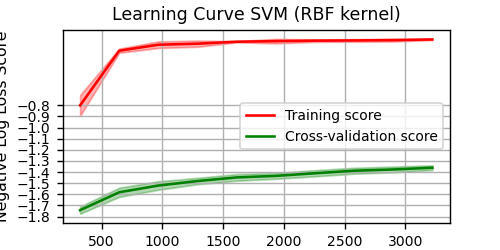

In [463]:
fig, ax = plt.subplots(2, 1, figsize=(4, 2))
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
#ax.set_yticks([-0.2,-0.4,-0.8,-1,-1.2,-1.4,-1.6,-1.8])
title = "Learning Curve SVM (RBF kernel)"

estimator = classifier(C=10,probability=True)
g=plot_learning_curve(estimator, title,train_data, train_labels, axes=ax, #ylim=(0, 0.9)
                      train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                      n_jobs=4)

In [461]:
ax.get_figure().savefig(os.path.join(classifier_name+'lcurve.svg'), dpi=300, format='svg', bbox_inches='tight')

## Validation curves

In [24]:
param_range = np.logspace(-5, 4, 20)
train_scores, test_scores = validation_curve(
    SVC(kernel='linear',probability=True), X_train, y_train, param_name="C", param_range=param_range,
    scoring='neg_log_loss', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [25]:
param_range = np.logspace(-5, 4, 30)
train_scores2, test_scores2 = validation_curve(
    SVC(kernel='linear',probability=True), X_train, y_train, param_name="C", param_range=param_range,
    scoring='neg_log_loss', n_jobs=-1)

train_scores_mean2 = np.mean(train_scores2, axis=1)
train_scores_std2 = np.std(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)
test_scores_std2 = np.std(test_scores2, axis=1)

In [33]:
param_range = np.logspace(-5, 4, 30)
train_scores_mean = np.mean(train_scores2, axis=1)
train_scores_std = np.std(train_scores2, axis=1)
test_scores_mean = np.mean(test_scores2, axis=1)
test_scores_std = np.std(test_scores2, axis=1)

<IPython.core.display.Javascript object>


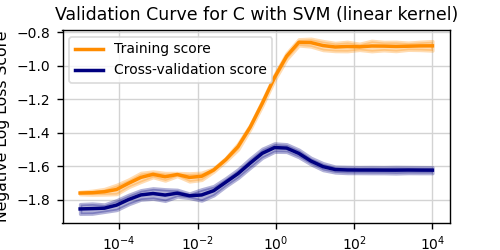

In [38]:
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 10    

fig, ax = plt.subplots(figsize=(4, 2))
ax.set_axisbelow(True)
ax.set_facecolor('white')
ax.grid(color='lightgrey')
ax.tick_params(bottom=True, left=True)
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
ax.xaxis.grid(True, which='minor')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')

plt.title("Validation Curve for C with SVM (linear kernel)",fontsize=BIGGER_SIZE)
plt.xlabel("C",fontsize=MEDIUM_SIZE)
plt.ylabel("Negative Log Loss Score",fontsize=MEDIUM_SIZE)

#plt.ylim(-0.01, 1.04)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.3,
                color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.3,
                 color="navy", lw=lw)
    
legend=plt.legend(loc="best",fontsize=SMALL_SIZE)
legend.get_frame().set_color('white')
legend.get_frame().set_edgecolor('lightgrey')
plt.savefig(os.path.join('vali_curve.svg'), dpi=300, format='svg', bbox_inches='tight')
#plt.show()

## Predictions file

In [160]:
train_data_file=selector.transform(train_data)
test_data_file=selector.transform(test_data)

In [213]:
model0.fit(train_data_file, train_labels)

SVC(C=10, probability=True)

In [215]:
predictions_file=classifier_name
predictions_for_file=model0.predict_proba(test_data_file)

In [216]:
# Build a submission
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename(predictions_file, 'csv'))
helpers.writePredictionsToCsv(predictions_for_file, pred_file_path, label_strings)